<h1 align='center'>Dropout as Regularization and Bayesian Approximation</h1>

 <h3 align='center'>Kovalev Evgeny, Chesakov Daniil, Vsevolod Glazov</h3>

### Import libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import time
import h5py
from scipy.ndimage.interpolation import rotate

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

import seaborn as sns
%matplotlib inline

import torch
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import pymc3 as pm

### 5.2. Dropout as Bayesian Approximation in Regression Task

Here we use the **_lean 2000_irradiance_** dataset.

In [3]:
!cat "data/lean2000_irradiance.txt"

# Solar Irradiance Reconstruction
# -----------------------------------------------------------------------
#                World Data Center for Paleoclimatology, Boulder
#                                   and
#                      NOAA Paleoclimatology Program
# -----------------------------------------------------------------------
# NOTE: PLEASE CITE CONTRIBUTORS WHEN USING THIS DATA!!!!!
# 
# 
# NAME OF DATA SET: Solar Irradiance Reconstruction
# LAST UPDATE: 7/2004 (Original receipt by WDC Paleo)
# 
# 
# CONTRIBUTOR: Judith Lean, Naval Research Laboratory
# IGBP PAGES/WDCA CONTRIBUTION SERIES NUMBER: 2004-035
# 
# 
# SUGGESTED DATA CITATION:  Lean, J.. 2004.
# Solar Irradiance Reconstruction.
# IGBP PAGES/World Data Center for Paleoclimatology 
# Data Contribution Series # 2004-035.
# NOAA/NGDC Paleoclimatology Program, Boulder CO, USA.
# 
# 
# ORIGINAL REFERENCE: Lean, J. 2000.
# Evolution of the Sun's Spectral Irradiance Since the Maunder Minimum.
# Geophysical Research Lett

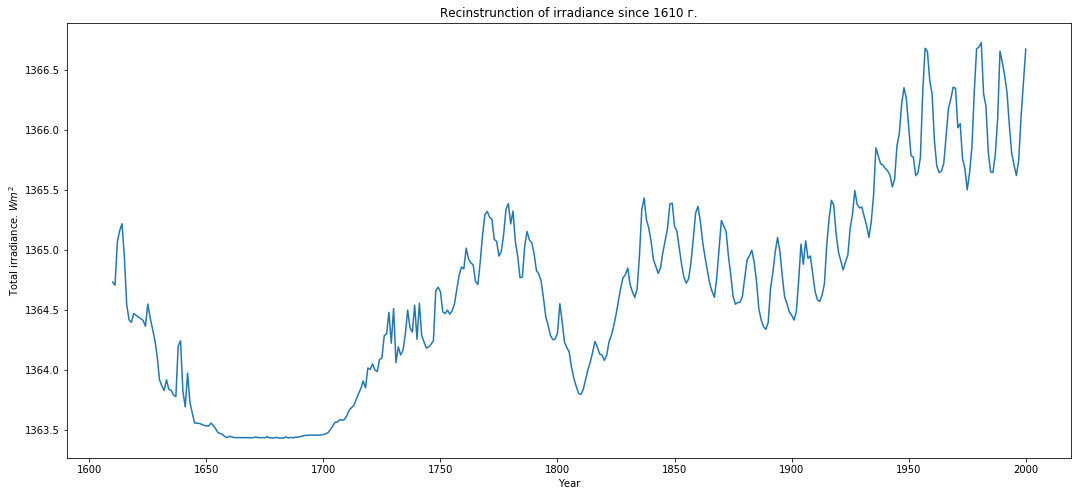

In [13]:
import pandas as pd
df = pd.read_table("data/lean2000_irradiance.txt",
                   comment='#',
                   header=None,
                   sep=' ',
                   names=["YEAR", "11yrCYCLE", "11yrCYCLE+BKGRND"])
X_train = df['YEAR'].values.reshape(-1, 1)
y_train = df['11yrCYCLE+BKGRND'].values.reshape(-1, 1)
X_test = np.arange(2001, 2200, 1)[:, None]

plt.figure(figsize=(18, 8))
# plt.subplot(1,2,1)
plt.plot(df['YEAR'].values.reshape(-1, 1),
         df['11yrCYCLE+BKGRND'].values.reshape(-1, 1))
plt.xlabel("Year")
plt.ylabel(r"Total irradiance. $Wm^2$")
plt.title("Recinstrunction of irradiance since 1610 г.")

from sklearn.preprocessing import StandardScaler
SS_X = StandardScaler().fit(X_train)
X_train = SS_X.transform(X_train)
X_test = SS_X.transform(X_test)
y_train = StandardScaler().fit_transform(y_train)

# plt.subplot(1,2,2)
# plt.plot(X_train, y_train)
# plt.title("Normalized data.")

plt.show()

We train a multilayer perceptron with 5 hidden layers, 1024 units in each layer, ReLU/Tanh non-linearities, and dropout with probability 0.2 after each weight layer. As pointed out by paper [[2](#Reference)], similar results can be obtained when using 4 hidden layers or dropout probability of 0.1.

We define the network with code below.

In [5]:
class MLP2(nn.Module):
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu'):
        super(MLP2, self).__init__()
        self.model = nn.Sequential()
        self.model.add_module('input', nn.Linear(1, hidden_layers[0]))
        if activation == 'relu':
            self.model.add_module('relu0', nn.ReLU())
        elif activation == 'tanh':
            self.model.add_module('tanh0', nn.Tanh())
        for i in range(len(hidden_layers)-1):
            self.model.add_module('dropout'+str(i+1), nn.Dropout(p=droprate))
            self.model.add_module('hidden'+str(i+1), nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            if activation == 'relu':
                self.model.add_module('relu'+str(i+1), nn.ReLU())
            elif activation == 'tanh':
                self.model.add_module('tanh'+str(i+1), nn.Tanh())
        self.model.add_module('dropout'+str(i+2), nn.Dropout(p=droprate))
        self.model.add_module('final', nn.Linear(hidden_layers[i+1], 1))
        
    def forward(self, x):
        return self.model(x)

Similar as last section, we implement a sklearn-like regressor for this MLP.

In [6]:
class MLP2Regressor:
    def __init__(self, hidden_layers=[1024, 1024, 1024, 1024, 1024], droprate=0.2, activation='relu', \
                 max_epoch=1000, lr=0.005, weight_decay=1e-6):
        self.max_epoch = max_epoch
        self.lr = lr
        self.model = MLP2(hidden_layers=hidden_layers, droprate=droprate, activation=activation)
        self.model.cuda()
        self.criterion = nn.MSELoss().cuda()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        
    def fit(self, X_train, y_train, verbose=True):
        X = Variable(torch.from_numpy(X_train).type(torch.FloatTensor)).cuda()
        y = Variable(torch.from_numpy(y_train).type(torch.FloatTensor)).cuda()
        print(self.model)
        for epoch in range(self.max_epoch):
            self.optimizer.zero_grad()
            outputs = self.model(X)
            loss = self.criterion(outputs, y)
            loss.backward()
            self.optimizer.step()
            if verbose:
                print('Epoch {} loss: {}'.format(epoch+1, loss.item()))
        return self

And the training code is below. We load our trained models here.

In [7]:
### Below is training code, uncomment to train your own model... ###
### Note: You need GPU and CUDA to run this section ###

# Define networks
mlp2 = [MLP2Regressor(activation='relu'),
        MLP2Regressor(activation='tanh')]
        
# Training, set verbose=True to see loss after each epoch.
[mlp.fit(X_train, y_train,verbose=False) for mlp in mlp2]

# Save torch models
for ind, mlp in enumerate(mlp2):
    torch.save(mlp.model, 'models/irradiance_mlp2_'+str(ind)+'.pth')


# Load saved models to CPU
mlp2_models = [torch.load('models/irradiance_mlp2_'+str(ind)+'.pth',map_location={'cuda:0': 'cpu'}) for ind in [0,1]]

MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024, bias=True)
    (relu0): ReLU()
    (dropout1): Dropout(p=0.2)
    (hidden1): Linear(in_features=1024, out_features=1024, bias=True)
    (relu1): ReLU()
    (dropout2): Dropout(p=0.2)
    (hidden2): Linear(in_features=1024, out_features=1024, bias=True)
    (relu2): ReLU()
    (dropout3): Dropout(p=0.2)
    (hidden3): Linear(in_features=1024, out_features=1024, bias=True)
    (relu3): ReLU()
    (dropout4): Dropout(p=0.2)
    (hidden4): Linear(in_features=1024, out_features=1024, bias=True)
    (relu4): ReLU()
    (dropout5): Dropout(p=0.2)
    (final): Linear(in_features=1024, out_features=1, bias=True)
  )
)
MLP2(
  (model): Sequential(
    (input): Linear(in_features=1, out_features=1024, bias=True)
    (tanh0): Tanh()
    (dropout1): Dropout(p=0.2)
    (hidden1): Linear(in_features=1024, out_features=1024, bias=True)
    (tanh1): Tanh()
    (dropout2): Dropout(p=0.2)
    (hidden2): Linear(in_features=

Below is the function doing the simulation for the regressors (**keep dropout enabled to generate samples**). Here, we simulate 10000 times. The simulation is very slow since we have many data points.

In [8]:
def predict_reg(model, X, T=10000):
    X = Variable(torch.from_numpy(X).type(torch.FloatTensor).cuda())
    model = model.train()
    Yt_hat = np.array([model(X).data.cpu().numpy() for _ in range(T)]).squeeze()
    model = model.eval()
    y_pred = model(X).data.cpu().numpy()
    model = model.train()
    return y_pred, Yt_hat

The simulation on CPU takes a lot of time so we uses GPU instead. Generating simulation results thus **requires GPU and CUDA**, and therefore, we provide the stored simulation results and commented out the simulation code.

In [9]:
# Simulation below is very slow. Run with GPU! #
### Uncomment to simulate ###

mlp2_models = [torch.load('models/irradiance_mlp2_'+str(ind)+'.pth') for ind in [0,1]]
y_relu_pred, y_hat = predict_reg(mlp2_models[0], X_test)
y_relu_mc = y_hat.mean(axis=0)
y_relu_mc_std = y_hat.std(axis=0)
y_tanh_pred, y_hat = predict_reg(mlp2_models[1], X_test)
y_tanh_mc = y_hat.mean(axis=0)
y_tanh_mc_std = y_hat.std(axis=0)
results = [y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std]
results = [x.reshape(-1).astype(str).tolist() for x in results]
open("models/mlp2_sim_irradiance_results.txt","w").write('\n'.join([','.join(res) for res in results]))


# Load saved simulation results
results = [res_array.split(',') for res_array in 
                      open("models/mlp2_sim_irradiance_results.txt","r").read().split('\n')]
results = np.array(results,dtype='f')
y_relu_pred,y_relu_mc,y_relu_mc_std,y_tanh_pred,y_tanh_mc,y_tanh_mc_std = results

We can compare the uncertainty we get through dropout with the uncertainty we get from a Gaussian process (GP). Below is the definition of our GP and since pymc is pretty slow, we commented out the sampling code and provide the generated samples.

We check the convergence of our GP model below:

The above tests demonstrate the convergence of the model.

Now, we use `sample_ppc` to generate posterior predictive for our test data. As above, we provide saved results since `sample_ppc` is slow.

Next, we compare those models for regression. The figures below is very similar to figures in paper [[2](#Reference)]. We intentionally made the plot titles same with those in the paper and the paper calls dropout as Monte Carlo dropout (MC dropout).

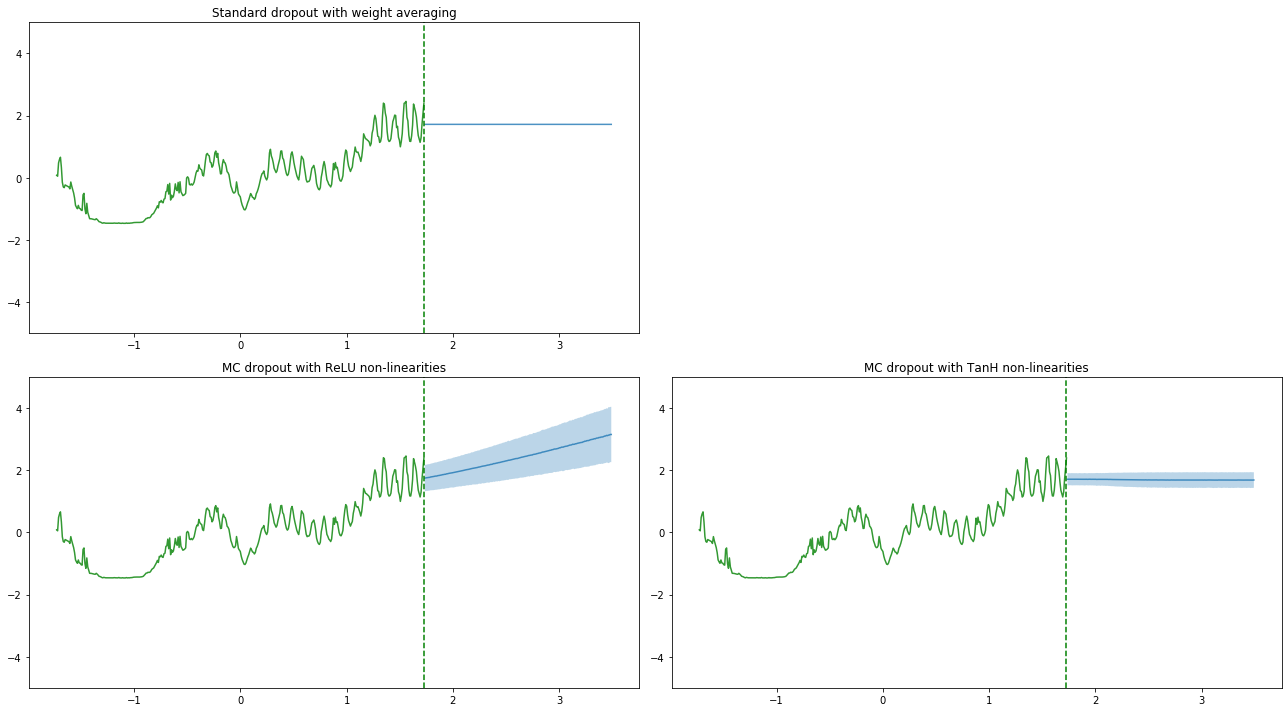

In [15]:
plt.figure(figsize=(18, 10))

plt.subplot(2, 2, 1)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_pred, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.title('Standard dropout with weight averaging');
plt.ylim([-5, 5]);

# plt.subplot(2, 2, 2)
# plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
# plt.plot(X_test.squeeze(), y_gp_pred, alpha=0.8);
# plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
# plt.fill_between(X_test.squeeze(), y_gp_pred-2*y_gp_std, y_gp_pred+2*y_gp_std, alpha=0.3);
# plt.title('Gaussian process with SE covariance function');
# plt.ylim([-20, 20]);

plt.subplot(2, 2, 3)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_relu_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_relu_mc-2*y_relu_mc_std, y_relu_mc+2*y_relu_mc_std, alpha=0.3);
plt.title('MC dropout with ReLU non-linearities');
plt.ylim([-5, 5]);

plt.subplot(2, 2, 4)
plt.plot(X_train.squeeze(), y_train.squeeze(), 'g', alpha=0.8);
plt.plot(X_test.squeeze(), y_tanh_mc, alpha=0.8);
plt.axvline(X_train.squeeze()[-1], color='g',linestyle='--');
plt.fill_between(X_test.squeeze(), y_tanh_mc-2*y_tanh_mc_std, y_tanh_mc+2*y_tanh_mc_std, alpha=0.3);
plt.title('MC dropout with TanH non-linearities');
plt.ylim([-5, 5]);

plt.tight_layout();

## RMSE and LL computing

In [10]:
!ls -l "../DropoutUncertaintyExps/UCI_Datasets/lean2000_irradiance/data"

total 1084
-rw-rw-r-- 1 vglasov vglasov  9774 окт 25 08:59 data.txt
-rw-rw-r-- 1 vglasov vglasov    19 окт 25 08:58 dropout_rates.txt
-rw-rw-r-- 1 vglasov vglasov     8 окт 25 08:58 index_features.txt
-rw-rw-r-- 1 vglasov vglasov     2 окт 25 08:58 index_target.txt
-rw-rw-r-- 1 vglasov vglasov  4665 окт 25 08:58 index_test_0.txt
-rw-rw-r-- 1 vglasov vglasov  4661 окт 25 08:58 index_test_10.txt
-rw-rw-r-- 1 vglasov vglasov  4680 окт 25 08:58 index_test_11.txt
-rw-rw-r-- 1 vglasov vglasov  4676 окт 25 08:58 index_test_12.txt
-rw-rw-r-- 1 vglasov vglasov  4666 окт 25 08:58 index_test_13.txt
-rw-rw-r-- 1 vglasov vglasov  4684 окт 25 08:58 index_test_14.txt
-rw-rw-r-- 1 vglasov vglasov  4683 окт 25 08:58 index_test_15.txt
-rw-rw-r-- 1 vglasov vglasov  4692 окт 25 08:58 index_test_16.txt
-rw-rw-r-- 1 vglasov vglasov  4675 окт 25 08:58 index_test_17.txt
-rw-rw-r-- 1 vglasov vglasov  4690 окт 25 08:58 index_test_18.txt
-rw-rw-r-- 1 vglasov vglasov  4692 окт 25 08:58 index_test_19.txt
-rw-rw-r-

In [1]:
import pandas as pd
df = pd.read_table("data/lean2000_irradiance.txt",
                   comment='#',
                   header=None,
                   sep=' ',
                   names=["YEAR", "11yrCYCLE", "11yrCYCLE+BKGRND"])

In [24]:
df.to_csv("../DropoutUncertaintyExps/UCI_Datasets/lean2000_irradiance/data/data.txt",
          header=None,
          sep="\t",
          index=False)

In [4]:
df[["YEAR", "11yrCYCLE+BKGRND"]].values

array([[1610.    , 1364.7338],
       [1611.    , 1364.7075],
       [1612.    , 1365.0675],
       [1613.    , 1365.1611],
       [1614.    , 1365.2197],
       [1615.    , 1364.9456],
       [1616.    , 1364.5469],
       [1617.    , 1364.4189],
       [1618.    , 1364.3983],
       [1619.    , 1364.4717],
       [1620.    , 1364.4574],
       [1621.    , 1364.4431],
       [1622.    , 1364.429 ],
       [1623.    , 1364.4147],
       [1624.    , 1364.366 ],
       [1625.    , 1364.5509],
       [1626.    , 1364.439 ],
       [1627.    , 1364.3447],
       [1628.    , 1364.2544],
       [1629.    , 1364.1193],
       [1630.    , 1363.9214],
       [1631.    , 1363.8699],
       [1632.    , 1363.8304],
       [1633.    , 1363.92  ],
       [1634.    , 1363.8397],
       [1635.    , 1363.833 ],
       [1636.    , 1363.7925],
       [1637.    , 1363.7799],
       [1638.    , 1364.2039],
       [1639.    , 1364.2444],
       [1640.    , 1363.8243],
       [1641.    , 1363.6943],
       [

In [25]:
import numpy as np
length = len(df)
for i in range(20):
    X = np.random.permutation(length)
    train_size = int(length * 0.9)
    np.savetxt("../DropoutUncertaintyExps/UCI_Datasets/lean2000_irradiance/data/index_train_%d.txt" % i,
               X[:train_size],
               fmt="%d")
    np.savetxt("../DropoutUncertaintyExps/UCI_Datasets/lean2000_irradiance/data/index_test_%d.txt" % i,
               X[train_size:],
               fmt="%d")

In [6]:
0.36204918649052326+\
0.288827995147438+\
0.2621658746343667+\
0.2619300192847441+\
0.29738176993628335+\
0.2897559436606662+\
0.2042557216019618+\
0.3258627579489848

2.2922292687049683

In [7]:
2.2922292687049683 / 8

0.28652865858812104